In this practical assignment you will learn how to work with neural networks. Various neural network packages are available in Python of which Google's TensorFlow is quite famous. We will use Chainer, which is another flexible neural network package.

Your code will be evaluated on clarity, conciseness and efficiency. Document your code. The resulting notebook including the required outputs should be converted to pdf and uploaded to Blackboard. Comments can be added in the notebook using markdown cells. Note that for code development you may want to use the PyCharm IDE, which facilitates debugging.

### Assignment 1

Go to the tutorial page for Chainer:

http://docs.chainer.org/en/stable/tutorial/basic.html

Implement <i>Example: Multi-layer Perceptron on MNIST</i>. You will train a model that learns to predict the label of a handwritten character based on the pixel input. 

Report the accuracy obtained after 20 epochs. Provide a motivated conclusion about the performance of the model.

-----

In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check
from chainer import report, training, utils, Variable
from chainer import iterators, optimizers, serializers
from chainer import Link, Chain, ChainList, datasets
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

This downloads the mnist dataset and caches it locally. We have 60.000 training samples and 10.000 test samples. The images are represented as 28x28 pixel grayscale images with values between 0. and 1. Those values are 'flattened' to arrays of size 784x1. 

In [2]:
train, test = datasets.get_mnist()
print "samples", len(train), len(test)
print "Input sample size", train[0][0].shape
print "Min and max", np.min(train[0][0]), np.max(train[0][0])


samples 60000 10000
Input sample size (784,)
Min and max 0.0 1.0


A nice feature of chainer is that it helps us to create batches of our training and test set using iterators. When training using stocastic gradient descent you don't want to use the same batches every time you do an iteration. So chainer will re-shuffle the samples for every iteration. 

In [3]:
train_iter = iterators.SerialIterator(train, batch_size=100, shuffle=True)
test_iter = iterators.SerialIterator(test, batch_size=100,
                                     repeat=False, shuffle=False)

Next we define our model. We do this by inherenting the chainer Chain class. It uses the smaller Link instances as arguments. These two classes are abstract classes that do not define the actual computation graph, but do help us with the parameters administration. The idea is that children of these classes define the actual computations that should be done, and can form reusable units that can be "chained" together. Chainer does provide some implementations of those two classes. We will use the Linear Link wich defines the $$y = Wx +b$$ operation. 

Our model consists of three layers. The first is going from the 784 input values to 100 output values. Second going from 100 to 100 and the last layer going from 100 to 10 output nodes. The first and second layer have a RELU activation function to introduce non linearity, these relu functions have no parameters and are therefore not parts of the Links(which for me was a bit confusing cause you lose the chainer idea a bit). But we combine these computational graph in the \_\_call\_\_ method.

In [4]:
class MLP(Chain):
    def __init__(self):
         super(MLP, self).__init__(
                l1=L.Linear(784, 100),
                l2=L.Linear(100, 100),
                l3=L.Linear(100, 10),
            )
    
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

Next we can complete our chain by adding classifier on top, that can calculate the loss given input and expected output. It calculates the soft_max_cross_entropy of the output of a predictor(in our case the MLP defined above).We also output the accuraccy so we can see the progress.  

In [5]:
class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__(predictor=predictor)
    
    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        report({'loss': loss, 'accuracy': accuracy}, self)
        return loss

Note that such a Classifier comes predefined in chainer. Next we want to learn our weights from the training data. This can be done by using a optimizer, usually Statistic gradient descent. This optimizer calculates how to change the weights parameters using backward propagation techniques. The gradients are saved inside the the chainer Variable element(abstraction of Links) and such can be used to update the actual values.

In [6]:
model = L.Classifier(MLP())
optimizer = optimizers.SGD()
optimizer.setup(model)

Now we make a updater class which uses this optimizer and our training data(accessed via train_iter). To update our actual weights. Trainer to execute this updater for 20 epochs. We also tell the trainer to output some extra data like, the performance on the test set, loss and accuracy on training set, epoch and progress. 

In [7]:
updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (20, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy']))
#trainer.extend(extensions.ProgressBar())
trainer.run()  


epoch       main/accuracy  validation/main/accuracy
1           0.679567       0.8554                    
2           0.87325        0.8933                    
3           0.895117       0.906                     
4           0.9043         0.9144                    
5           0.911967       0.918                     
6           0.917117       0.9232                    
7           0.921417       0.925                     
8           0.92555        0.9278                    
9           0.928583       0.9321                    
10          0.932117       0.9337                    
11          0.934883       0.936                     
12          0.938233       0.9384                    
13          0.940283       0.9395                    
14          0.942483       0.9429                    
15          0.945          0.9448                    
16          0.946233       0.9454                    
17          0.9483         0.9475                    
18          0.949917       0.9

The model gets a accuracy of .9523 on the validation set. Which comes down to an error of 4.77% which is pretty nice. The best score at the moment is an error of .23% using convolutional deep learning techniques http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354. The best with a fully connected neural network is 1.6% https://www.microsoft.com/en-us/research/publication/best-practices-for-convolutional-neural-networks-applied-to-visual-document-analysis/. And uses 800 hidden units in stead of 100.

### Assignment 2

In this assignment you will run the exact same model but now for a problem where we predict fMRI BOLD responses as people are shown handwritten digits (6 versus 9) in an MRI scanner. Data can be downloaded here:

https://drive.google.com/file/d/0B-sN_eJ65cGUbmcwTm1hVWhueUE/edit?usp=sharing

Note that you need to adapt the code slightly since we are now dealing with a regression problem from pixels onto BOLD responses (actually single trial beta estimates). That is, create a Regressor class to replace the Classifier class. Use mean squared error as an error function.

Report the mean squared error on the validation data after running the model for 500 epochs. Provide a motivated conclusion about the performance of the model.

----

We have a data set of 100 samples, we split into 80 training samples and 20 test samples and then shuffle them. As input vector we use the image pixels, as output we use the 3092 BOLD values. 

In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check
from chainer import report, training, utils, Variable
from chainer import iterators, optimizers, serializers
from chainer import Link, Chain, ChainList, datasets
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

In [2]:
from scipy.io import loadmat
from chainer.datasets import TupleDataset, split_dataset_random
def get_fmri_dataset():
    data = loadmat('../datasets/69dataset.mat')
    # we have to predict the pixels given the pixels
    Y = data['X'].astype(np.float32)
    X = data['I'].astype(np.float32)    
    
    # Normalize
    Y = (Y - np.mean(Y,0))/np.std(Y,0)
    X = (X - np.mean(X))/np.std(X)
    
    return TupleDataset(X,Y)

ds = get_fmri_dataset()

# make train test, randomly since labels are ordered
train, test = split_dataset_random(ds, 80)
train[0][0].shape, train[0][1].shape

((784,), (3092,))

We have 784 pixels for the image and 3092 bold response. We change our model a bit. We need more output nodse and maybe we could use more hidden nodes. (We define it as a variable) 

In [3]:
class MLP(Chain):
    def __init__(self,hidden_nodes=100):
         super(MLP, self).__init__(
                l1=L.Linear(784, hidden_nodes),
                l2=L.Linear(hidden_nodes, hidden_nodes),
                l3=L.Linear(hidden_nodes, 3092),
            )
    
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

In [4]:
class Regression(Chain):
    def __init__(self, predictor):
        super(Regression, self).__init__(predictor=predictor)
    
    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.mean_squared_error(y, t)
        report({'loss': loss}, self)
        return loss

I define my own trainer extension to be able to plot the loss progress on the validation set(http://docs.chainer.org/en/stable/_modules/chainer/training/extensions/print_report.html#PrintReport). 

In [5]:
import sys
from chainer import reporter
import chainer.serializer as serializer_module
from chainer.training import extension
import chainer.training.trigger as trigger_module
%matplotlib inline
class PlotReport(extension.Extension):
    def __init__(self, plot_key='validation/main/loss', 
                 log_report='LogReport', out=sys.stdout):
        self._plot_key = plot_key
        self._log_report = log_report
        self._out = out
        self.per_epoch = {}
        self._log_len = 0  # number of observations already printed
        
    def __call__(self, trainer):
        out = self._out

        # delete the printed contents from the current cursor
        out.write('\033[J')


        log_report = self._log_report
        if isinstance(log_report, str):
            log_report = trainer.get_extension(log_report)
        elif isinstance(log_report, log_report_module.LogReport):
            log_report(trainer)  # update the log report
        else:
            raise TypeError('log report has a wrong type %s' %
                            type(log_report))

        log = log_report.log
        for l in log:
            if self._plot_key in l:
                self.per_epoch[l['epoch']] = l[self._plot_key]
    
        
    def plot(self):
        import matplotlib.pyplot as plt
        plt.plot(self.per_epoch.keys(), self.per_epoch.values())
        plt.ylabel(self._plot_key)
        plt.xlabel("epoch")
        plt.show()

We now initialize our model for different number of hidden nodes, then setup the optimizer, prepare iterators, set extensions. And lastly plot the found results

Testing 100 nodes


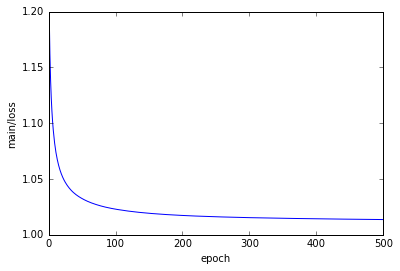

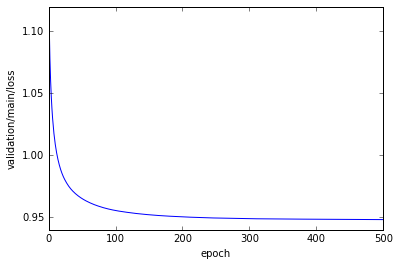

In [8]:
HIDDEN_NODES = [100]
for hn in HIDDEN_NODES:
    print "Testing",hn,"nodes"
    # model with hn number of nodes
    model = Regression(MLP(hn))
    #optimize that model
    optimizer = optimizers.SGD()
    optimizer.setup(model)
    
    #prepare iterators
    train_iter = iterators.SerialIterator(train, batch_size=20, shuffle=True)
    test_iter = iterators.SerialIterator(test, batch_size=20,
                                         repeat=False, shuffle=False)
    
    #trainer
    updater = training.StandardUpdater(train_iter, optimizer)
    trainer = training.Trainer(updater, (500, 'epoch'), out='result')
    trainer.extend(extensions.Evaluator(test_iter, model))
    
    #Make sure validation loss is tracked for plot
    trainer.extend(extensions.LogReport())
    pr_training = PlotReport(plot_key='main/loss')
    trainer.extend(pr_training)
    pr_validation = PlotReport(plot_key='validation/main/loss')
    trainer.extend(pr_validation)
    #run
    trainer.run() 
    
    #afterwards plot
    pr_training.plot()
    pr_validation.plot()

We see a very nice error plot for each of the hidden nodes number. And the errors don't differ much for the different hidden nodes numbers. However the actual error achieved is not really low. This can have multiple causes but the most likely reason to me seems that most of the bold responses are not related to the actual image shown. We already know that the neural network should be able to "understand" if the input image is a 6 or 9. It thus should at least be able to learn a distribution of the bold responses given that image is 6 or 9, and we would like to also infer something from how the 6 or 9 is actually drawn(but these might require a more complex neural network). But given that the error stay really high i suspect that most bold responses are irrelevant for the picture shown.